<p> Code found <a href="https://www.youtube.com/watch?v=M2PqI2JD2jo&feature=youtu.be">on the internet</a>.</p>

In [1]:
from numpy import *
from numpy.linalg import *
import matplotlib.pyplot as plt
from matplotlib import cm
from numba import jit

In [2]:
maxIter = 200000 # Total number of time iterations.
Re      = 500.0  # Reynolds number.

finegrain = 0.50*4;

nx = int(512*finegrain)
ny = int(256*finegrain)
ly=ny-1.0
q = 9 # Lattice dimensions and populations.

obstacle_length = 0.5

cx = nx/4
cy=ny/2

#Reynolds length scale
r=obstacle_length*ny

uLB     = 0.04                       # Velocity in lattice units.
nulb    = uLB*r/Re;
omega = 1.0 / (3.*nulb+0.5); # Relaxation parameter.


In [3]:
c = array([(x,y) for x in [0,-1,1] for y in [0,-1,1]]) # Lattice velocities.
t = 1./36. * ones(q)                                   # Lattice weights.

t[asarray([norm(ci)<1.1 for ci in c])] = 1./9.; t[0] = 4./9.
noslip = [c.tolist().index((-c[i]).tolist()) for i in range(q)] 

i1 = arange(q)[asarray([ci[0]<0  for ci in c])] # Unknown on right wall.
i2 = arange(q)[asarray([ci[0]==0 for ci in c])] # Vertical middle.
i3 = arange(q)[asarray([ci[0]>0  for ci in c])] # Unknown on left wall.


In [4]:
sumpop = lambda fin: sum(fin,axis=0) # Helper function for density computation.
@jit(parallel=True)
def equilibrium(rho,u):              # Equilibrium distribution function.
    cu   = 3.0 * dot(c,u.transpose(1,0,2))
    usqr = 3./2.*(u[0]**2+u[1]**2)
    feq = zeros((q,nx,ny))
    for i in range(q): feq[i,:,:] = rho*t[i]*(1.+cu[i]+0.5*cu[i]**2-usqr)
    return feq

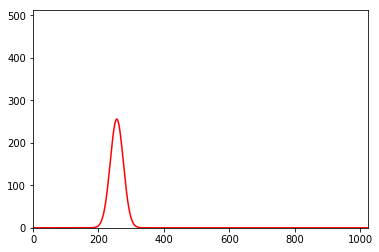

In [5]:

gaussian = lambda x, amp, mu, sigma:amp* ny * exp( -(x-mu)**2 / (2*sigma**2))

x = linspace(0, nx, 1000)
y = gaussian(x, obstacle_length, nx/4, 20)

plt.plot(x, y, 'r-')
plt.xlim(0, nx)
plt.ylim(0, ny)
plt.show()
plt.close()

In [ ]:
obstacle = fromfunction(lambda x,y: gaussian(x, obstacle_length, nx/4, 20) > y, (nx,ny))

vel = fromfunction(lambda d,x,y: (1-d)*uLB*(1.0+1e-4*sin(y/ly*2*pi)),(2,nx,ny))
feq = equilibrium(1.0,vel); fin = feq.copy()


In [ ]:
for time in range(maxIter): 
    
    fin[i1,-1,:] = fin[i1,-2,:] # Right wall: outflow condition.
    rho = sumpop(fin)           # Calculate macroscopic density and velocity.
    u = dot(c.transpose(), fin.transpose((1,0,2)))/rho

    u[:,0,:] =vel[:,0,:] # Left wall: compute density from known populations.
    rho[0,:] = 1./(1.-u[0,0,:]) * (sumpop(fin[i2,0,:])+2.*sumpop(fin[i1,0,:]))

    feq = equilibrium(rho,u) # Left wall: Zou/He boundary condition.
    fin[i3,0,:] = fin[i1,0,:] + feq[i3,0,:] - fin[i1,0,:]
    fout = fin - omega * (fin - feq)  # Collision step.
    for i in range(q):
        fout[i,obstacle] = fin[noslip[i],obstacle]
    for i in range(q): # Streaming step.
        fin[i,:,:] = roll(roll(fout[i,:,:],c[i,0],axis=0),c[i,1],axis=1)
 
    if (time%100==0): # Visualization
        plt.clf()
        plt.imshow(sqrt(u[0]**2+u[1]**2).transpose(),cmap=cm.Reds)
        plt.title("Iteration %d, Re=%d" % (time, Re))
        
        filename = "palabos/constriction_one_side_finegrain%diteration%dre%dobstruction%d.png" % (finegrain*100, time, Re,100*obstacle_length)
        
        #plt.show()
        plt.savefig(filename)
        plt.close()  
